In [1]:
import os
import sys

from pprint import pprint
from typing import NamedTuple

import matplotlib.pyplot as plt
import matplotlib

from PyPDF2 import PdfFileReader

import pandas as pd

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))

In [3]:
def list_pdfs(path):
    for f in os.listdir(path):
        new_path = os.path.join(path, f)
        if os.path.isdir(new_path):
            yield from list_pdfs(new_path)
        elif os.path.isfile(new_path):
            if new_path[-4:].lower() == '.pdf':
                yield new_path

In [4]:
def count_images(pdf):
    count = 0
    for page_no in range(pdf.numPages):
        page = pdf.getPage(page_no)
        pprint(page)
        if '/Resources' in page and '/XObject' in page['/Resources']:
            xObject = page['/Resources']['/XObject'].getObject()
            for obj in xObject:
                if '/Subtype' in xObject[obj] and xObject[obj]['/Subtype'] == '/Image':
                    count += 1
                elif '/PTEX.FileName' in xObject[obj]:
                    filename_ = xObject[obj]['/PTEX.FileName']
                    if 'figure' in filename_.lower():
                        count += 1
                    if 'graficas' in filename_.lower():
                        count += 1
                    if 'image' in filename_.lower():
                        count += 1
                else:
                    print('---------')
                    print(obj)
                    print(xObject[obj])
                    
    return count

In [5]:
class DocStats(NamedTuple):
    path: str
    pages: int
    page_layout: str
    image_count: int
    size: int
    has_outline: bool
    has_form: bool
    creator: str
        
    def as_dict(self):
        return {
            'path': self.path,
            'pages': self.pages,
            'page_layout': self.page_layout,
            'size': self.size,
            'has_outline': self.has_outline,
            'has_form': self.has_form,
            'image_count': self.image_count,
            'creator': self.creator,
        }


In [6]:
def file_stats(pdf):
    with open(pdf, 'rb') as pdf_file:
        try:
            reader = PdfFileReader(pdf_file)
            stats = DocStats(
                path=pdf,
                pages=reader.getNumPages(),
                page_layout=reader.getPageLayout(),
                creator=reader.getDocumentInfo() and reader.getDocumentInfo().creator,
                size=os.path.getsize(pdf),
                has_outline=False # bool(reader.getOutlines()),
                has_form=False # bool(reader.getFields()),
                image_count=0 # count_images(reader),
            )
            return (stats)
        except Exception as e:
            raise

In [7]:
def dataset_to_dataframe(dataset_name):
    dataset_dir = os.path.join(BASE_DIR, 'datasets', dataset_name)
    assert os.path.isdir(dataset_dir), '%s is not a directory' % dataset_dir

    docstats = []
    errored_paths = []
    for pdf in list_pdfs(dataset_dir):    
        try:
            docstats.append(file_stats(pdf))
        except Exception as e:
            errored_paths.append((pdf, e))
    print("Documents analyzed:\t%d" % len(docstats))
    print("Documents errored:\t%d" % len(errored_paths))
    pprint(errored_paths)
    
    stats = pd.DataFrame([stat.as_dict() for stat in docstats])
    return stats

In [8]:
def analyze_document_size(dataset):
    fig, ax = plt.subplots(figsize = (16,10))

    file_sizes = dataset['size'] / 1000
    file_sizes.plot(kind='hist', density=True, bins=20, alpha=0.65)
    file_sizes.plot(kind='kde')


    # Quantile lines
    quant_50, quant_75, quant_95 = (
        file_sizes.quantile(0.5), 
        file_sizes.quantile(0.75),
        file_sizes.quantile(0.95),
    )

    # [quantile, opacity, length]
    quants = [
        [quant_50, 1, 0.36],
        [quant_75, 1, 0.46],
        [quant_95, 1, 0.56]
    ]


    for i in quants:
        ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel("file size, KB")
    x_min, x_max = ax.get_xlim()
    xsize = (x_max - x_min)

    # Y
    y_min,y_max = ax.get_ylim()
    ysize = (y_max - y_min)
    ax.set_yticklabels([])
    ax.set_ylabel("")

    # Annotations
    ax.text(quant_50 - .25, ysize * 0.37, "50th Percentile = %.2d KB" % quant_50, size = 12)
    ax.text(quant_75 - .25, ysize * 0.47, "75th Percentile = %.2d KB" % quant_75, size = 12)
    ax.text(quant_95 - .25, ysize * 0.57, "95th Percentile = %.2d KB" % quant_95, size = 12)


    plt.title('File size distribution')
    plt.xlabel('size, KB')
    plt.ylabel('Files')
    plt.show()
    
    print(file_sizes.describe())

In [9]:
def analyze_num_pages(dataset):
    fig, ax = plt.subplots(figsize = (16,10))

    pages = dataset['pages']
    pages.plot(kind='hist', density=True, bins=20, alpha=0.65)
    pages.plot(kind='kde')


    # Quantile lines
    quant_50, quant_75, quant_95 = (
        pages.quantile(0.5), 
        pages.quantile(0.75),
        pages.quantile(0.95),
    )

    # [quantile, opacity, length]
    quants = [
        [quant_50, 1, 0.36],
        [quant_75, 1, 0.46],
        [quant_95, 1, 0.56]
    ]


    for i in quants:
        ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel("Pages")
    # ax.set_xlim(-10000, 60000)

    # Y
    y_min,y_max = ax.get_ylim()
    ax.set_yticklabels([])
    ax.set_ylabel("")

    # Annotations
    ax.text(quant_50 - .13, y_max * 0.37, "50th Percentile = %d" % quant_50, size = 12)
    ax.text(quant_75 - .13, y_max * 0.47, "75th Percentile = %d" % quant_75, size = 12)
    ax.text(quant_95 - .25, y_max * 0.57, "95th Percentile = %d" % quant_95, size = 12)


    plt.title('Num pages distribution')
    plt.xlabel('pages')
    plt.ylabel('Files')
    plt.show()

    print(pages.describe())

In [10]:
def analyze_image_count(dataset):
    # images per doc
    fig, ax = plt.subplots(figsize = (16,10))

    images = dataset['image_count']
    images.plot(kind='hist', density=True, bins=20, alpha=0.65)
    images.plot(kind='kde')


    # Quantile lines
    quant_50, quant_75, quant_95 = (
        images.quantile(0.5), 
        images.quantile(0.75),
        images.quantile(0.95),
    )

    # [quantile, opacity, length]
    quants = [
        [quant_50, 1, 0.36],
        [quant_75, 1, 0.46],
        [quant_95, 1, 0.56]
    ]


    for i in quants:
        ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel("Pages")
    # ax.set_xlim(-10000, 60000)

    # Y
    y_min,y_max = ax.get_ylim()
    ax.set_yticklabels([])
    ax.set_ylabel("")

    # Annotations
    ax.text(quant_50 - .13, y_max * 0.37, "50th Percentile = %d" % quant_50, size = 12)
    ax.text(quant_75 - .13, y_max * 0.47, "75th Percentile = %d" % quant_75, size = 12)
    ax.text(quant_95 - .25, y_max * 0.57, "95th Percentile = %d" % quant_95, size = 12)


    plt.title('Num image count')
    plt.xlabel('images')
    plt.ylabel('Files')
    plt.show()
    
    # images per page
    fig, ax = plt.subplots(figsize = (16,10))
    
    pages = dataset['pages']
    images = dataset['image_count']
    
    xmax = pages.quantile(.95)
    ymax = images.quantile(.95)

    plt.hist2d(pages, images, bins=64, range=[[0, xmax],[0, ymax]])
    plt.xlabel('pages in document')
    plt.ylabel('images in document')
    plt.show()

In [11]:
def analyze_creators(dataset):
    #     creators = pd.Series([stats.creator for stats in docstats])
    creators = dataset['creator']
    print(creators.value_counts().nlargest(n=5))

In [12]:
def analyze_page_layout(dataset):
    layouts = dataset['page_layout']
    print(layouts.value_counts().nlargest(n=5))

In [13]:
def analyze_outlines(dataset):
    outlines = dataset['has_outline']
    print(outlines.value_counts())
    print(outlines.describe())

In [14]:
def analyze_dataset(dataset):    
    print('Document Size Analysis')
    analyze_document_size(dataset)
    print()
    
    print('Num pages in document analysis')
    analyze_num_pages(dataset)
    print()
    
    print('Document creators analysis')
    analyze_creators(dataset)
    print()
    
    print('Document layouts analysis')
    analyze_page_layout(dataset)
    print()
    
    # print('Document outlines analysis')
    # analyze_outlines(dataset)
    # print()

In [15]:
arxiv = dataset_to_dataframe('arxiv')

Documents analyzed:	3606
Documents errored:	40
[('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/arxiv/2021.02443.pdf',
  PdfReadError('EOF marker not found')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/arxiv/2021.03532.pdf',
  ValueError("invalid literal for int() with base 10: b''")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/arxiv/2021.00080.pdf',
  PdfReadError("Unexpected escaped string: b'h'")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/arxiv/2021.02108.pdf',
  PdfReadError('EOF marker not found')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/arxiv/2021.01022.pdf',
  PdfReadError('EOF marker not found')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/arxiv/2021.01367.pdf',
  PdfReadError("Unexpected escaped string: b'h'")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/arxiv/2021.01047.pdf',
  PdfReadErro

Document Size Analysis


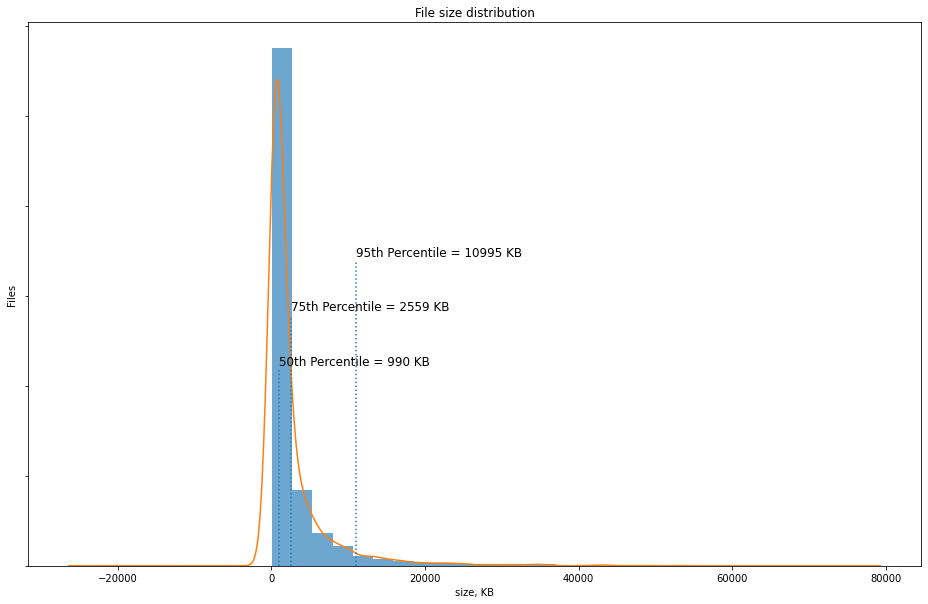

count     3606.000000
mean      2684.344783
std       4832.291424
min         45.781000
25%        447.908750
50%        990.261000
75%       2559.005000
max      52865.297000
Name: size, dtype: float64

Num pages in document analysis


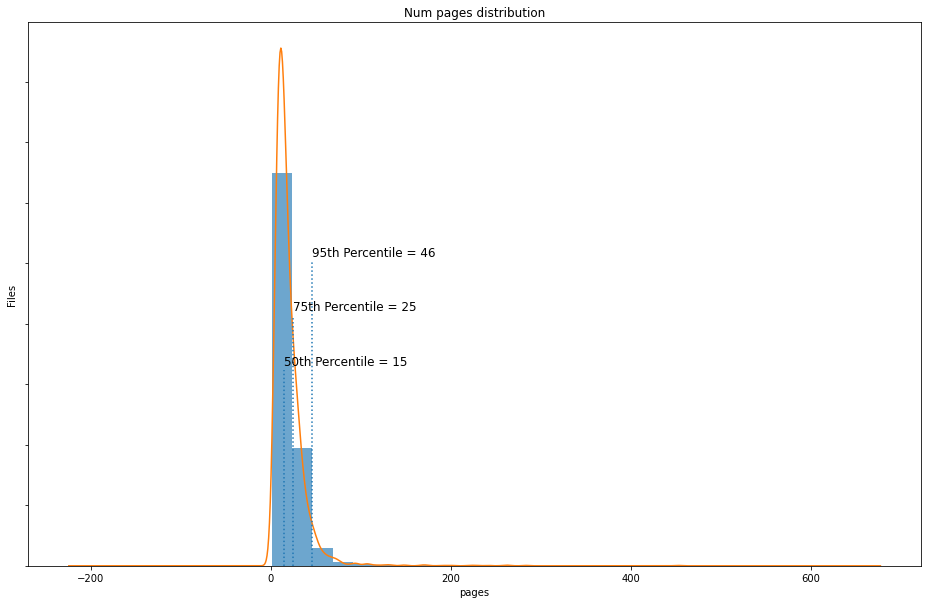

count    3606.000000
mean       19.755685
std        19.674210
min         1.000000
25%        10.000000
50%        15.000000
75%        25.000000
max       452.000000
Name: pages, dtype: float64

Document creators analysis
LaTeX with hyperref                                    2968
TeX                                                      87
Microsoft® Word 2016                                     53
dvips(k) 2020.1 Copyright 2020 Radical Eye Software      51
Word                                                     34
Name: creator, dtype: int64

Document layouts analysis
/OneColumn         31
/TwoColumnLeft      3
/SinglePage         2
/TwoColumnRight     1
Name: page_layout, dtype: int64

Document outlines analysis
True     2711
False     895
Name: has_outline, dtype: int64
count     3606
unique       2
top       True
freq      2711
Name: has_outline, dtype: object



In [16]:
analyze_dataset(arxiv)

In [17]:
cv = dataset_to_dataframe('cv')

Documents analyzed:	3247
Documents errored:	17
[('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/cv/3012.pdf',
  PdfReadError('EOF marker not found')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/cv/2751.pdf',
  PdfReadError("Unexpected destination '/__WKANCHOR_2'")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/cv/1961.pdf',
  PdfReadError("Unexpected destination '/__WKANCHOR_2'")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/cv/1212.pdf',
  PdfReadError("Unexpected destination '/__WKANCHOR_2'")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/cv/1124.pdf',
  PdfReadError('EOF marker not found')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/cv/3069.pdf',
  PdfReadError('Expected object ID (5 0) does not match actual (4 0); xref table not zero-indexed.')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/cv/3013.pdf',
  P

Document Size Analysis


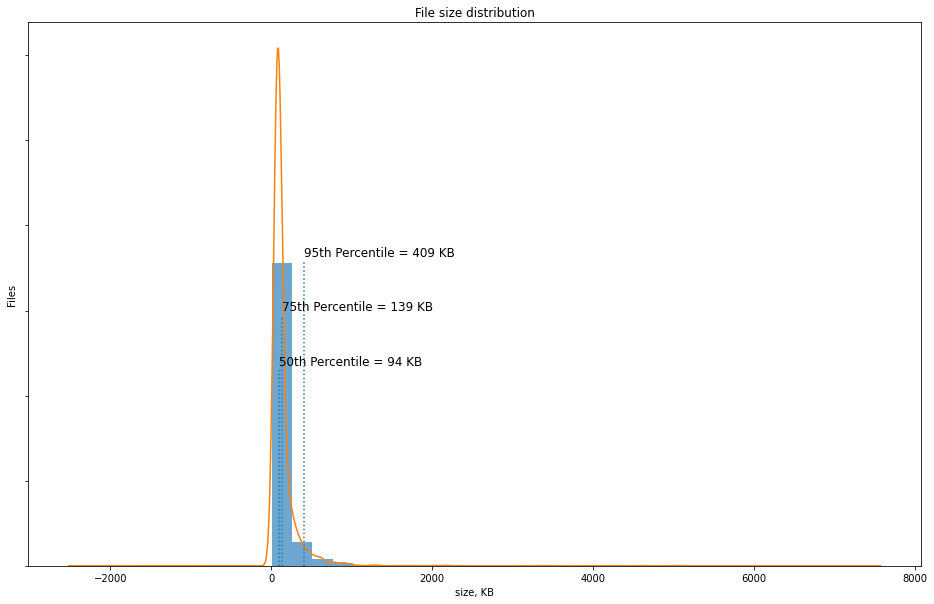

count    3247.000000
mean      142.423470
std       204.206316
min         6.707000
25%        68.937000
50%        94.645000
75%       139.738000
max      5050.273000
Name: size, dtype: float64

Num pages in document analysis


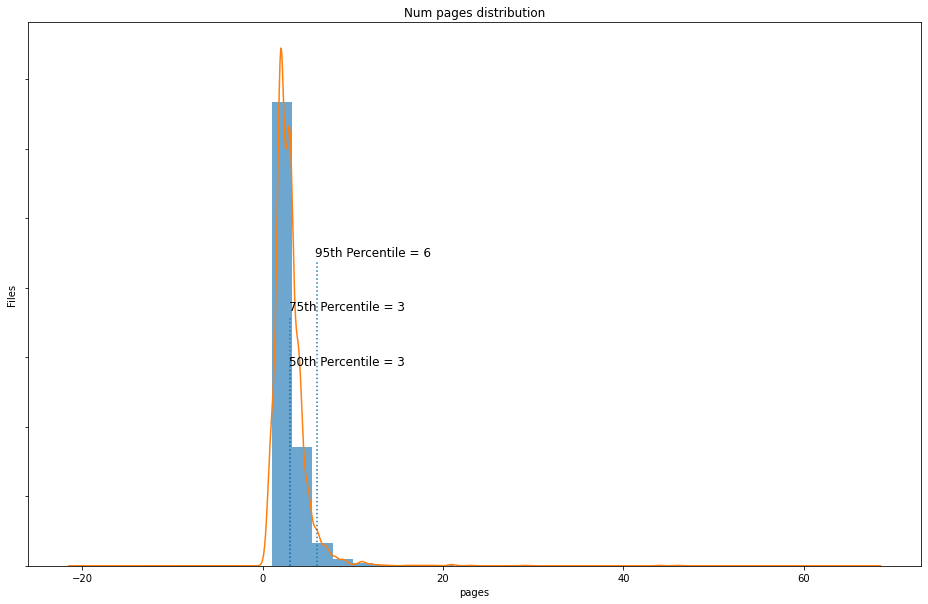

count    3247.000000
mean        3.000616
std         2.053505
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        46.000000
Name: pages, dtype: float64

Document creators analysis
Writer                         2295
Microsoft® Word 2010            121
PScript5.dll Version 5.2.2      110
Microsoft® Word 2013            105
Microsoft® Office Word 2007      72
Name: creator, dtype: int64

Document layouts analysis
/OneColumn     96
/SinglePage     4
Name: page_layout, dtype: int64

Document outlines analysis
False    2275
True      972
Name: has_outline, dtype: int64
count      3247
unique        2
top       False
freq       2275
Name: has_outline, dtype: object



In [18]:
analyze_dataset(cv)

In [21]:
tech = dataset_to_dataframe('tech')

Documents analyzed:	1394
Documents errored:	83
[('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/tech/Vim '
  'for Humans.pdf',
  PdfReadError('Multiple definitions in dictionary at byte 0x1c24cc for key /Author')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/tech/The '
  'Misuse of Colour in Science Communication - 2020 (s41467-020-19160-7).pdf',
  PdfReadError("Unexpected destination 'unknown'")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/tech/Hash '
  'and Displace - Efficient Evaluation of Minimum Perfect Hash Functions - '
  '1999 (10.1.1.148.7694).pdf',
  PdfReadError('Multiple definitions in dictionary at byte 0x38130 for key /Creator')),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/datasets/tech/Why '
  'BitBlt was So Successful - SIGGRAPH 84 (pike84bitblt).pdf',
  TypeError("argument of type 'NullObject' is not iterable")),
 ('/home/anxolerd/ws/github.com/anxolerd/benchmarking_grobid/data

Document Size Analysis


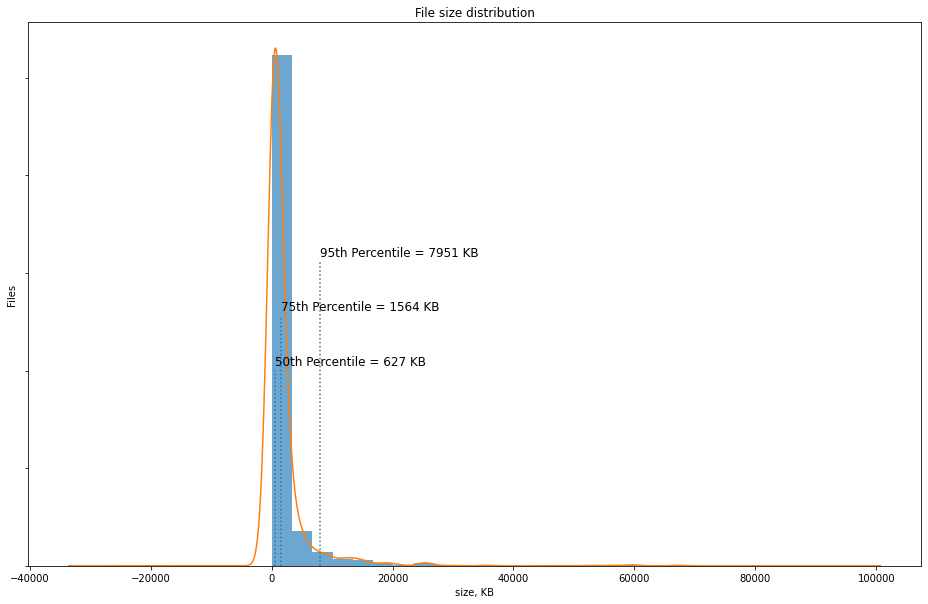

count     1394.000000
mean      1957.943852
std       4868.186405
min         17.159000
25%        291.793750
50%        627.457000
75%       1564.493750
max      67135.442000
Name: size, dtype: float64

Num pages in document analysis


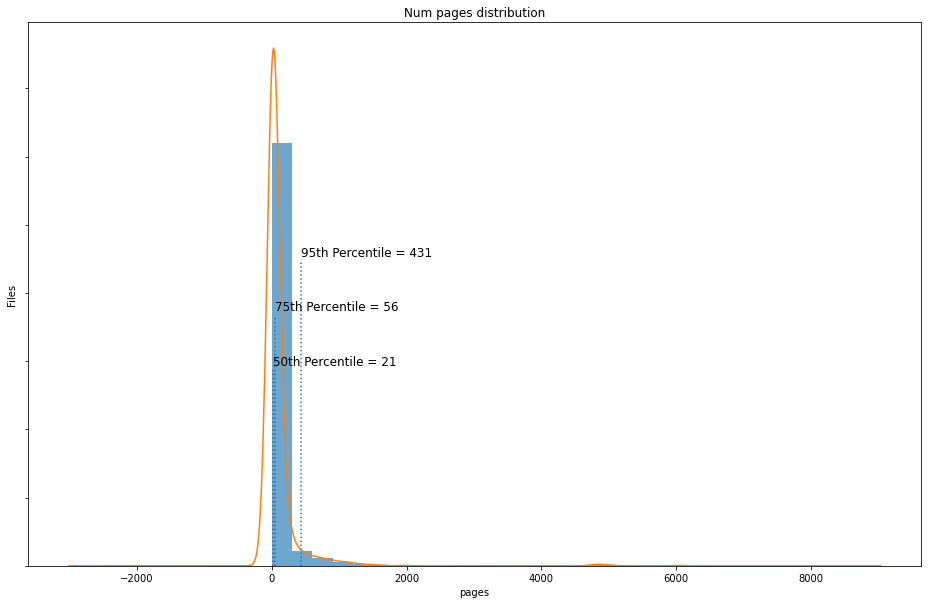

count    1394.000000
mean      103.576758
std       378.617133
min         1.000000
25%        12.000000
50%        21.000000
75%        56.000000
max      6018.000000
Name: pages, dtype: float64

Document creators analysis
LaTeX with hyperref package    234
TeX                            159
PScript5.dll Version 5.2.2      44
Microsoft® PowerPoint® 2010     37
FrameMaker 10.0.2               24
Name: creator, dtype: int64

Document layouts analysis
/SinglePage        56
/OneColumn         21
/TwoPageRight       1
/TwoColumnRight     1
Name: page_layout, dtype: int64

Document outlines analysis
False    913
True     481
Name: has_outline, dtype: int64
count      1394
unique        2
top       False
freq        913
Name: has_outline, dtype: object



In [23]:
analyze_dataset(tech)

In [38]:
tech.path.map(lambda x: x.rsplit('/')).map(lambda x: x[-1])[666]

'Fibre Channel Fundamentals.pdf'